In [113]:

def translate(dataset):
    img, (rel_questions, rel_answers), (norel_questions, norel_answers) = dataset
    colors = ['red ', 'green ', 'blue ', 'orange ', 'gray ', 'yellow ']
    answer_sheet = ['yes', 'no', 'rectangle', 'circle', '1', '2', '3', '4', '5', '6']
    questions = rel_questions + norel_questions
    answers = rel_answers + norel_answers

    print(rel_questions)
    print(rel_answers)


    for question,answer in zip(questions,answers):
        query = ''
        query += colors[question.tolist()[0:6].index(1)]

        if question[6] == 1:
            if question[8] == 1:
                query += 'shape?'
            if question[9] == 1:
                query += 'left?'
            if question[10] == 1:
                query += 'up?'
        if question[7] == 1:
            if question[8] == 1:
                query += 'closest shape?'
            if question[9] == 1:
                query += 'furthest shape?'
            if question[10] == 1:
                query += 'count?'

        ans = answer_sheet[answer]
        print(query,'==>', ans)
    #cv2.imwrite('sample.jpg',(img*255).astype(np.int32))
    cv2.imshow('img',cv2.resize(img,(512,512)))
    cv2.waitKey(0)
    
def decode_question(questions, answers):
    for question,answer in zip(questions,answers):
        query = ''
        query += colors[question.tolist()[0:6].index(1)]
        
        # non-relational question
        if question[NOREL_Q_IDX] == 1:
            if question[SUB_Q_IDX] == 1:
                query += 'shape?'
            if question[SUB_Q_IDX + 1] == 1:
                query += 'left?'
            if question[SUB_Q_IDX + 2] == 1:
                query += 'up?'
                
        # relational question
        if question[REL_Q_IDX] == 1:
            if question[SUB_Q_IDX] == 1:
                query += 'closest shape?'
            if question[SUB_Q_IDX + 1] == 1:
                query += 'furthest shape?'
            if question[SUB_Q_IDX + 2] == 1:
                query += 'count?'

        ans = answer_sheet[answer]
        print(query,'==>', ans)


In [ ]:
import pickle
import cv2
import numpy as np
import os
import random
import warnings
import argparse
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


In [2]:
data = pickle.load(open("relational-networks/data/sort-of-clevr.pickle", 'rb'))

In [3]:
len(data[0]), len(data[1])

(9800, 200)

In [53]:
cv2.imshow('img', cv2.resize(data[0][0][0], (512, 512)))

In [61]:
cv2.imwrite('sample1.jpg',(data[0][0][0]*255).astype(np.int32))

True

In [6]:
cv2.imshow('img', data[0][0][0])

In [58]:
plt.imshow(cv2.cvtColor(cv2.resize(data[0][0][0], (512, 512)), cv2.COLOR_BGR2RGB))

error: OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDcn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [60]:
cv2.resize(data[0][0][0], (512, 512))

(512, 512, 3)

Although neural networks like CNNs and MLPs are powerful in a variety of tasks, they struggle with relational reasoning. Relation network is a neural network module designed for relational reasoning tasks. It constrains the functional form of NN to avoid 

Relation Networks (RN) can be simply represented by equation below, where $O$ is a set of objects, denoted as $O = \{o_1, o_2, ..., o_n\}$. Meanwhile, $f_{\phi}$ and $g_{\theta}$ are MLPs with learnable and differentiable parameters $\phi$ and $\theta$.

$$RN(O) = f_{\phi} \Big( \sum_{i, j} g_{\theta} (o_i, o_j)\Big)$$


In [156]:
class ConvInputModel(nn.Module):
    def __init__(self):
        super(ConvInputModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.batchNorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.batchNorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.batchNorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.batchNorm4 = nn.BatchNorm2d(256)
        
    def forward(self, img):
        x = self.conv1(img)
        x = F.relu(x)
        x = self.batchNorm1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batchNorm2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.batchNorm3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.batchNorm4(x)
        return x 

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()]

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [130]:
model = ConvInputModel()

In [138]:
.shape

torch.Size([3, 75, 75])

In [139]:
model(torch.Tensor(data[0]).permute(2,0,1))

ValueError: expected 4D input (got 3D input)

In [125]:
random.seed(1)
np.random.seed(1)

TRAIN_SIZE, TEST_SIZE = 9800, 200
IMAGE_SIZE, SYMBOL_SIZE = 75, 5
QUESTION_ENCODING_SIZE = 11  ## 6 for one-hot vector of color, 2 for question type (rel or norel), 3 for question subtype
NOREL_Q_IDX, REL_Q_IDX = 6, 7
SUB_Q_IDX = 8
ANSWER_ENCODING = {
    'no': 0, 'yes': 1, 'rectangle': 2, 'circle': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9
}
COLORS_LIST = ['red ', 'green ', 'blue ', 'orange ', 'gray ', 'yellow ']
ANSWERS_LIST = ['no', 'yes', 'rectangle', 'circle', '1', '2', '3', '4', '5', '6']

nb_questions = 10
dirs = './data'

COLORS = [
    (0,0,255),##r
    (0,255,0),##g
    (255,0,0),##b
    (0,156,255),##o
    (128,128,128),##k
    (0,255,255)##y
]

try:
    os.makedirs(dirs)
except:
    print('directory {} already exists'.format(dirs))

def generate_new_center(objects):
    while True:
        valid_new_center = True
        center = np.random.randint(0 + SYMBOL_SIZE, IMAGE_SIZE - SYMBOL_SIZE, 2)        
        if len(objects) > 0:
            for color, c, shape in objects:
                if ((center - c) ** 2).sum() < ((SYMBOL_SIZE * 2) ** 2):
                    valid_new_center = False
        if valid_new_center:
            return center
        
def generate_new_object(objects, color_id, img):
    # generate a new valid center
    center = generate_new_center(objects)
    # sample a shape from rectangle or circle of equal probabiliy
    if random.random() < 0.5:
        start = (center[0] - size, center[1] - size)
        end = (center[0] + size, center[1] + size)
        cv2.rectangle(img, start, end, COLORS[color_id], -1)
        objects.append((color_id, center, 'rectangle'))
    
    else:
        center_ = (center[0], center[1])
        cv2.circle(img, center_, size, COLORS[color_id], -1)
        objects.append((color_id, center, 'circle'))
        
def generate_non_relational_question(objects):
    question = np.zeros((QUESTION_ENCODING_SIZE))
    color_id = random.randint(0,5)
    question[color_id] = 1
    question[NOREL_Q_IDX] = 1
    subtype = random.randint(0,2)
    question[subtype + SUB_Q_IDX] = 1
    
    if subtype == 0:
        # query shape -> rectangle/circle 
        answer = ANSWER_DICT[objects[color_id][2]]
    elif subtype == 1: 
        # query horizontal position is on the left -> yes/no
        horizontal_left = (objects[color_id][1][0] < IMAGE_SIZE / 2).astype(int)
        answer = 1 - horizontal_left
    elif subtype == 2:
        # query vertical position is on the top -> yes/no
        vertical_top = (objects[color_id][1][1] < IMAGE_SIZE / 2).astype(int)
        answer = 1 - vertical_top
        
    return question, answer 

def generate_relational_question(objects):
    question = np.zeros((QUESTION_ENCODING_SIZE))
    color_id = random.randint(0,5)
    question[color_id] = 1
    question[REL_Q_IDX] = 1
    subtype = random.randint(0,2)
    question[subtype + SUB_Q_IDX] = 1
    
    if subtype in [0, 1]:
        # query closest-to or furthest-from -> rectangle / circle
        curr_obj = objects[color_id][1]
        dist_list = [((curr_obj - obj[1]) ** 2).sum() for obj in objects]
        dist_list[dist_list.index(0)] = math.inf
        closest_ind = dist_list.index(min(dist_list))
        furthest_ind = dist_list.index(max(dist_list))
        if subtype == 0:
            answer = ANSWER_DICT[objects[closest_ind][2]]
        else:
            answer = ANSWER_DICT[objects[furthest_ind][2]]

    elif subtype == 2:
        """count->1~6"""
        curr_obj = objects[color_id][2]
        count = -1
        for obj in objects:
            if obj[2] == curr_obj:
                count += 1 
        answer = count + 4
        
    return question, answer 

def sample_one_image():
    
    objects = []
    rel_questions, rel_answers = [], []
    norel_questions, norel_answers = [], []
    
    # Getting a white image canvas
    img = np.ones((IMAGE_SIZE, IMAGE_SIZE, 3)) * 255
    
    # Adding 6 objects, one color each
    for color_id, color in enumerate(COLORS):  
        generate_new_object(objects, color_id, img)
    
    # Sample questions 
    for _ in range(nb_questions):
        norel_question, norel_answer = generate_non_relational_question(objects)
        rel_question, rel_answer = generate_relational_question(objects)
        norel_questions.append(norel_question)
        norel_answers.append(norel_answer)
        rel_questions.append(rel_question)
        rel_answers.append(rel_answer)
    
    relations = (rel_questions, rel_answers)
    norelations = (norel_questions, norel_answers)
    
    img = img/255.
    dataset = (img, relations, norelations)
    return dataset, objects

directory ./data already exists


In [147]:
img_data = []
for _ in range(TEST_SIZE):
    one_data, one_obj = sample_one_image()
    img_data.append(one_data[0])

In [148]:
img_data = np.array(img_data, dtype=np.int32)

In [154]:
model(torch.Tensor(img_data).permute(0,3,1,2)).shape

torch.Size([200, 256, 5, 5])

In [155]:
one_obj

[(0, array([17, 25]), 'rectangle'),
 (1, array([22, 42]), 'rectangle'),
 (2, array([13, 47]), 'circle'),
 (3, array([66, 62]), 'rectangle'),
 (4, array([53, 35]), 'circle'),
 (5, array([28, 28]), 'rectangle')]

In [127]:
decode_question(*data[2])

yellow left? ==> no
red shape? ==> rectangle
gray up? ==> no
red up? ==> yes
green up? ==> yes
yellow left? ==> no
gray shape? ==> rectangle
red up? ==> yes
yellow up? ==> no
gray up? ==> no


In [123]:
cv2.imwrite('sample1new.jpg',(data[0]*255).astype(np.int32))

True

In [102]:
obj

[(0, array([ 6, 17]), 'rectangle'),
 (1, array([44, 24]), 'rectangle'),
 (2, array([60, 64]), 'circle'),
 (3, array([ 7, 38]), 'circle'),
 (4, array([49, 58]), 'rectangle'),
 (5, array([42, 67]), 'circle')]

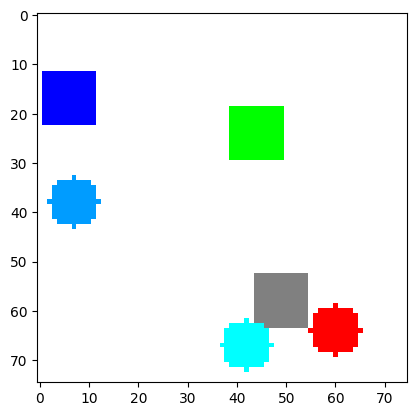

In [110]:
# plt.imshow(data[0])
plt.imshow((data[0] * 255).astype(int))